# Applying ML to Predict Hotel Booking Cancellations

## The Project:
The hospitality industry relies heavily on accurate demand forecasting to optimize revenue and manage inventory. One significant challenge for hotels is the prediction of cancellations, which can disrupt business operations, lead to lost revenue, and impact customer satisfaction. Machine learning techniques offer a promising solution for predicting cancellations and mitigating their effects.

Hence, in this project, I aim to develop an ML model for hotel cancellation prediction, leveraging historical booking data and other relevant features. I will explore various algorithms and techniques, including logistic regression, random forest, gradient boosting, to identify the most effective approach for predicting cancellations. Ultimately, my goal is to provide a valuable tool for hotels to optimize their revenue management and improve customer satisfaction by accurately predicting and managing cancellations.

## The Dataset:

The dataset has been collected from <a href="https://www.sciencedirect.com/science/article/pii/S2352340918315191">ScienceDirect</a> and consists of hotel demand data for 2 hotels (H1 and H2) in Europe. Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking.

## Import Necessary Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import eli5

## Import and Verify the Data

In [7]:
data = pd.read_csv('hotel_bookings.csv')

In [8]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

As can be seen, the data has been loaded properly. There are a total of 119390 rows of data spread across 32 columns as expected.

The data types seem to be okay and do not require any changes at the moment.

## Data Cleaning

### Dealing with Null Values

In machine learning, null or missing values refer to data points that are not available or not recorded in a dataset. These values can be caused by various reasons, such as data entry errors, incomplete records, or data processing issues.

Null values can cause errors in the analysis and prediction of machine learning models, as many algorithms cannot handle missing data. Therefore, it is important to properly deal with null values in a dataset before training the model.

Dealing with null values properly can improve the accuracy and reliability of the model's output, as it ensures that the machine learning algorithm is making predictions based on the maximum amount of available data. Additionally, properly handling null values can help prevent bias in the machine learning model and improve the overall quality of the analysis.

In [11]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [15]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest should be self-explanatory.

replacements = {"children:": 0.0, "country": "Unknown", "agent": 0, "company": 0}

data = data.fillna(replacements)

# "meal" contains values "Undefined", which is equal to SC.
data["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entries with 0 adults, 0 children and 0 babies.
# I'm dropping these entries with no guests.
zero_guests = data.loc[data["adults"] + data["children"] + data["babies"]==0].index
data.drop(zero_guests, inplace=True)

In [16]:
data.shape

(119210, 32)

After dealing with the null values, we are left with 119210 rows from the initial 119390.

### Dealing with Duplicates

Dealing with duplicate values is important for machine learning projects as they can affect the quality of the dataset and lead to biased or inaccurate model predictions. Removing or handling duplicate values properly can help ensure that the machine learning model is trained on high-quality data and can make reliable predictions.

Duplicate values occur when there are identical or nearly identical data points in a dataset. These duplicates can occur due to errors in data entry or data collection, or because of the way the data was merged from multiple sources. In some cases, duplicates can be intentional, such as when a dataset contains multiple measurements of the same variable.

Duplicate values can cause several issues in machine learning projects. Firstly, they can lead to over-representation of certain data points, which can create bias in the analysis and predictions of the machine learning model. Secondly, duplicates can increase the computational complexity of the analysis, as the same data points are being analyzed multiple times. Finally, duplicates can cause issues with model validation, as the same data points may appear in both the training and testing datasets, leading to over-optimistic performance metrics.

Handling duplicate values properly can improve the quality of the dataset and the accuracy of the machine learning model. It can also help ensure that the model is making unbiased predictions based on high-quality data. Therefore, it is important to carefully consider how to handle duplicate values in a machine learning project.

In [17]:
data.duplicated().sum()

31980

In [18]:
data.drop_duplicates(inplace=True)

In [19]:
data.shape

(87230, 32)

As can be seen, we had over 31000 duplicate values, accounting about 27% of the total data. After dropping them, we are left with 87230 rows of data.

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in any machine learning project, as it helps to understand the data, identify patterns, and select appropriate features for training the model. EDA provides insights into the relationships between the variables in the dataset, which can help to optimize the machine learning model and improve its predictive performance.

EDA involves a range of statistical and graphical techniques to summarize and visualize the dataset. These techniques include descriptive statistics, correlation analysis, scatter plots, histograms, and box plots, among others. Through these techniques, EDA can identify missing values, outliers, and anomalies in the dataset, and help to prepare the data for modeling.

The importance of EDA in machine learning projects can be summarized in the following points:

1. **Data Understanding**: EDA helps to understand the characteristics and structure of the data, including the distribution of the variables, the presence of outliers and missing values, and the relationships between the variables. This understanding can help to determine the appropriate data preprocessing and feature engineering techniques required for the machine learning model. <br><br>

2. **Feature Selection**: EDA can help to identify the most important features for the machine learning model. By analyzing the correlations between the features and the target variable, EDA can help to select the most relevant features and eliminate the redundant ones. This can improve the model's performance and reduce its computational complexity. <br><br>

3. **Model Optimization**: EDA can help to optimize the machine learning model by identifying the best hyperparameters for the algorithm. By analyzing the performance of the model with different hyperparameter values, EDA can help to identify the best parameter settings for the algorithm, improving its predictive accuracy and generalization.

### Origin of Guests

In [53]:
guest_countries = data['country'].value_counts()
guest_countries

PRT    27355
GBR    10424
FRA     8823
ESP     7244
DEU     5385
       ...  
MMR        1
BFA        1
CYM        1
MLI        1
KHM        1
Name: country, Length: 178, dtype: int64

Since there are a lot of countries, but only a few have too many guests coming from there, I will only look at the top 10 countries by bookings.

In [57]:
top_10 = guest_countries.head(10)
top_10 = pd.DataFrame({'country': top_10.index.values, 'guests': top_10.values})
others = sum(guest_countries[10:])
top_10 = top_10.append({'country': 'other', 'guests': others}, ignore_index=True)

/var/folders/7p/m7gs_hkn58qbs70h8pztg9480000gn/T/ipykernel_68707/2589386483.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'country': 'other', 'guests': others}, ignore_index=True)


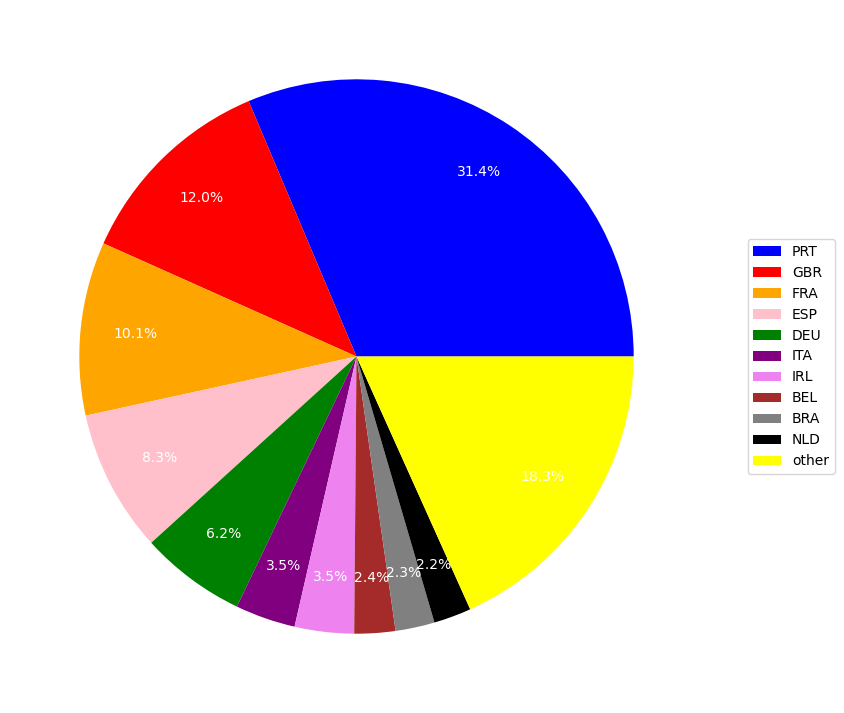

In [68]:
plt.figure(figsize=(9,9))
plt.pie(top_10['guests'], autopct='%1.1f%%', textprops={'color':'white'}, pctdistance=0.8, colors=['blue', 'red', 'orange', 'pink', 'green', 'purple', 'violet', 'brown', 'gray', 'black', 'yellow'])
plt.legend(top_10['country'], loc='right', bbox_to_anchor=(1.2,0.5))
plt.show()

As can be seen from the chart, most guests hail from Europe, with Portugal bringing in more than 31% of the total guests.